In [90]:
# ============ (一) 讀取必要套件 + CUDA測試 ============

import os
import re
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# 簡單的 CUDA 測試
print("===================================")
print("        CUDA 測試程式碼開始        ")
print("===================================")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 驅動版本: {torch.version.cuda}")
    print(f"CUDA CUDNN 版本: {torch.backends.cudnn.version()}")
    print(f"CUDA 設備數量: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA 設備 {i}: {torch.cuda.get_device_name(i)}")
    print(f"當前使用的 CUDA 設備: {torch.cuda.current_device()}")
else:
    print("CUDA 不可用。請檢查：1. GPU 驅動，2. CUDA Toolkit 版本，3. PyTorch 安裝版本…")

print("===================================")
print("          CUDA 測試程式碼結束       ")
print("===================================")


        CUDA 測試程式碼開始        
PyTorch 版本: 2.6.0.dev20241221+cu126
CUDA 可用: True
CUDA 驅動版本: 12.6
CUDA CUDNN 版本: 90501
CUDA 設備數量: 1
CUDA 設備 0: NVIDIA GeForce RTX 3050 Laptop GPU
當前使用的 CUDA 設備: 0
          CUDA 測試程式碼結束       


In [91]:
# ============ (二)-(1) 資料處理與清理函數 ============

import os

def clean_text(txt: str) -> str:
    """簡單文本清理，去除多餘空白和雜訊。"""
    if not isinstance(txt, str):
        return ""
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip()

def parse_cnbc_time(t):
    """解析 CNBC 的時間格式: '7:51 PM ET Fri, 17 July 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t, '%I:%M %p ET %a, %d %B %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_guardian_time(t):
    """解析 Guardian 的時間格式: '18-Jul-20'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%d-%b-%y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def parse_reuters_time(t):
    """解析 Reuters 的時間格式: 'Jul 18 2020'"""
    if not isinstance(t, str):
        return None
    try:
        dt = datetime.strptime(t.strip(), '%b %d %Y')
        return dt.strftime('%Y-%m-%d')
    except:
        return None

def load_cnbc(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: CNBC CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_cnbc_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'CNBC'
    return df

def load_guardian(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Time', 'Headlines']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Guardian CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = ""  # Guardian 無 Description
    df['date'] = df['Time'].apply(parse_guardian_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Guardian'
    return df

def load_reuters(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    expected_cols = ['Headlines', 'Time', 'Description']
    for col in expected_cols:
        if col not in df.columns:
            print(f"警告: Reuters CSV 缺少欄位 '{col}'")
    df['headline'] = df['Headlines'].fillna("").apply(clean_text)
    df['article_content'] = df['Description'].fillna("").apply(clean_text)
    df['date'] = df['Time'].apply(parse_reuters_time)
    df = df[['date', 'headline', 'article_content']].dropna(subset=['date', 'headline'])
    df['source'] = 'Reuters'
    return df

def load_cnn_articles(base_dir: str) -> pd.DataFrame:
    """
    載入所有 CNN 文章，並整理成 DataFrame。
    (資料夾結構: base_dir/YYYY-MM-DD/*.txt)
    """
    records = []
    for date_folder in os.listdir(base_dir):
        date_path = os.path.join(base_dir, date_folder)
        if os.path.isdir(date_path):
            for file_name in os.listdir(date_path):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(date_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        content = clean_text(content)
                        if content:  # 確保內容非空
                            records.append({
                                'date': date_folder,  # 假設資料夾名稱即為日期
                                'headline': "",  # CNN 無標題
                                'article_content': content,
                                'source': 'CNN'
                            })
    df_cnn = pd.DataFrame(records)
    df_cnn['date'] = pd.to_datetime(df_cnn['date'], errors='coerce')
    df_cnn = df_cnn.dropna(subset=['date'])
    df_cnn['date'] = df_cnn['date'].dt.strftime('%Y-%m-%d')
    return df_cnn

def merge_news(cnbc_csv, guardian_csv, reuters_csv, cnn_articles_dir):
    """
    讀取並合併 CNBC、Guardian、Reuters 和 CNN 的新聞資料。
    """
    cnbc_df = load_cnbc(cnbc_csv)
    guardian_df = load_guardian(guardian_csv)
    reuters_df = load_reuters(reuters_csv)
    cnn_df = load_cnn_articles(cnn_articles_dir)

    df_news = pd.concat([cnbc_df, guardian_df, reuters_df, cnn_df], ignore_index=True)
    df_news['date'] = pd.to_datetime(df_news['date'])
    df_news.sort_values('date', inplace=True)
    df_news.reset_index(drop=True, inplace=True)
    return df_news

def load_sp500(sp_csv_path: str) -> pd.DataFrame:
    df_sp = pd.read_csv(sp_csv_path, on_bad_lines='skip', engine='python')
    df_sp.rename(columns={'Date':'date','S&P500':'sp_close'}, inplace=True)
    df_sp['date'] = pd.to_datetime(df_sp['date'], errors='coerce')
    df_sp.sort_values('date', inplace=True)
    df_sp.dropna(subset=['date','sp_close'], inplace=True)
    return df_sp


# ============ (二)-(2) 讀取 article.csv (Reddit/Twitter 文章標題) ============

def read_article_csv(csv_path: str) -> pd.DataFrame:
    """
    讀取只有 'Date' 和 'Title' 欄位的 CSV，若有錯誤行則跳過。
    回傳包含 date, headline, article_content (空), source='Reddit/Twitter'
    """
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
    df.rename(columns={"Date": "date", "Title": "headline"}, inplace=True)

    # 新增空的 article_content
    df['article_content'] = ""
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date', 'headline'])
    df['headline'] = df['headline'].apply(clean_text)
    df['source'] = "Reddit/Twitter"
    return df



In [92]:
# ============ (二)-(3) FinBERT 情緒分析相關函數 ============

def setup_finbert_pipeline():
    """初始化 FinBERT pipeline (若 GPU 可用則使用 GPU)"""
    tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    device = 0 if torch.cuda.is_available() else -1
    finbert_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print(f"FinBERT pipeline 使用的設備: {'GPU (0)' if device == 0 else 'CPU'}")
    return finbert_pipeline

def batch_sentiment(text_list, pipeline_fn, batch_size=16, max_length=128):
    """
    分批呼叫 transformers pipeline，並使用 tqdm 顯示進度。
    若有錯誤行就跳過。
    """
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis Batches"):
        batch_texts = text_list[i:i+batch_size]
        try:
            batch_out = pipeline_fn(
                batch_texts,
                truncation=True,
                max_length=max_length
            )
            for out in batch_out:
                label = out['label'].lower()
                score = out['score']
                if label == 'positive':
                    results.append(+score)
                elif label == 'negative':
                    results.append(-score)
                else:
                    results.append(0.0)
        except Exception as e:
            print(f"批次 {i//batch_size + 1} 解析錯誤: {e}")
            results.extend([0.0]*len(batch_texts))
    return results

def compute_daily_sentiment(df_news: pd.DataFrame, sentiment_pipeline,
                            batch_size=16, max_length=128) -> pd.DataFrame:
    """
    對 headline & article_content 做批次情緒分析，
    並計算每日 mean_headline_sent, mean_content_sent
    """
    print("開始批次情緒分析 (FinBERT) ...")

    # headline
    headlines = df_news['headline'].tolist()
    print("-> 分析 Headline")
    headline_scores = batch_sentiment(headlines, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    # content
    contents = df_news['article_content'].tolist()
    print("-> 分析 Content")
    content_scores = batch_sentiment(contents, sentiment_pipeline, batch_size=batch_size, max_length=max_length)

    df_news['headline_sent'] = headline_scores
    df_news['content_sent']  = content_scores

    print("-> 彙整當日情緒...")
    daily_sentiment = (
        df_news
        .groupby('date', as_index=False)
        .agg({'headline_sent':'mean','content_sent':'mean'})
        .rename(columns={
            'headline_sent': 'mean_headline_sent',
            'content_sent':  'mean_content_sent'
        })
    )
    print("情緒分析完成。若出現負值，代表負面新聞居多。")
    return daily_sentiment


In [93]:
# ============ (二)-(4) 特徵工程 + 建立標籤 ============

def create_labels_for_prediction(df: pd.DataFrame, mode='classification'):
    """
    mode='classification': 隔日漲(1)/跌(0)
    mode='regression': 預測隔日收盤價
    """
    df['sp_close_next'] = df['sp_close'].shift(-1)
    df = df.dropna(subset=['sp_close_next'])
    if mode == 'classification':
        df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)
    else:
        df['target'] = df['sp_close_next']
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df['MA_5'] = df['sp_close'].rolling(window=5).mean()
    df['MA_10'] = df['sp_close'].rolling(window=10).mean()

    # RSI
    delta = df['sp_close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # MACD
    ema_12 = df['sp_close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['sp_close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    df['BB_upper'] = df['MA_10'] + 2 * df['sp_close'].rolling(window=10).std()
    df['BB_lower'] = df['MA_10'] - 2 * df['sp_close'].rolling(window=10).std()

    df.dropna(inplace=True)
    return df

def add_sentiment_features(df: pd.DataFrame, sentiment_col='mean_article', prefix='article', lags=[1,2,3]) -> pd.DataFrame:
    """
    為了將 mean_article 與 mean_content 分開處理，增加 prefix 做區分。
    """
    # e.g. sentiment_col='mean_article', prefix='article'
    df[f'{prefix}_sent_change_1'] = df[sentiment_col].diff(1)
    df[f'{prefix}_sent_change_2'] = df[sentiment_col].diff(2)
    df[f'{prefix}_sent_change_3'] = df[sentiment_col].diff(3)
    for lag in lags:
        df[f'{prefix}_sent_lag_{lag}'] = df[sentiment_col].shift(lag)
    # 注意: 不在這裡 dropna，改放在最後一次呼叫後再處理
    return df

def add_sp500_features(df: pd.DataFrame, lags=[1,2,3], rolling_window=5) -> pd.DataFrame:
    df['sp_return'] = df['sp_close'].pct_change()
    for lag in lags:
        df[f'sp_return_lag_{lag}'] = df['sp_return'].shift(lag)
    df[f'sp_return_mean_{rolling_window}'] = df['sp_return'].rolling(window=rolling_window).mean()
    for lag in lags:
        df[f'sp_close_lag_{lag}'] = df['sp_close'].shift(lag)
    return df

def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # 技術指標
    df = add_technical_indicators(df)

    # 分別對 mean_article, mean_content 做 add_sentiment_features
    df = add_sentiment_features(df, sentiment_col='mean_article', prefix='article', lags=[1,2,3])
    df = add_sentiment_features(df, sentiment_col='mean_content', prefix='content', lags=[1,2,3])

    # S&P500 特徵
    df = add_sp500_features(df, lags=[1,2,3], rolling_window=5)

    # 在最後統一 dropna
    df.dropna(inplace=True)

    if 'date' not in df.columns:
        raise KeyError("'date' 欄位在特徵工程後遺失。")

    return df


In [94]:
# ============ (三) 定義模型訓練 & 交叉驗證 ============

def train_random_forest(X_train, y_train):
    clf = RandomForestClassifier(
        n_estimators=150, random_state=42, class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgboost(X_train, y_train):
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
        predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
        gpu_id=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_lightgbm(X_train, y_train):
    device_type = 'gpu' if torch.cuda.is_available() else 'cpu'
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        device=device_type,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=31,
        min_data_in_leaf=10,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_catboost(X_train, y_train):
    task_type = 'GPU' if torch.cuda.is_available() else 'CPU'
    clf = cb.CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=5,
        class_weights=[2,1],
        task_type=task_type,
        devices='0',
        verbose=0,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def train_mlp(X_train, y_train):
    clf = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    clf.fit(X_train, y_train)
    return clf

def get_stacking_model():
    est_rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    est_xgb = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    est_lgbm = lgb.LGBMClassifier(random_state=42)
    est_cb = cb.CatBoostClassifier(iterations=100, verbose=0, random_state=42)

    stacking_clf = VotingClassifier(
        estimators=[
            ('rf', est_rf),
            ('xgb', est_xgb),
            ('lgb', est_lgbm),
            ('cat', est_cb)
        ],
        voting='soft'
    )
    return stacking_clf

def train_stacking(X_train, y_train):
    stacking_clf = get_stacking_model()
    stacking_clf.fit(X_train, y_train)
    return stacking_clf

def evaluate_classification(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return acc, f1, auc

def timeseries_cv_and_train(X, y, model_fn, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    acc_scores = []
    f1_scores = []
    auc_scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold_idx+1}/{n_splits} 開始...")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_, y_val = y[train_idx], y[val_idx]

        model = model_fn(X_train, y_train_)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:,1] if hasattr(model, "predict_proba") else None

        acc, f1, auc = evaluate_classification(y_val, y_pred, y_prob)
        acc_scores.append(acc)
        f1_scores.append(f1)
        auc_scores.append(auc if auc is not None else 0)

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(auc_scores)
    print(f"\n=== TimeSeriesSplit 平均 ACC: {avg_acc:.4f}, F1: {avg_f1:.4f}, AUC-ROC: {avg_auc:.4f} ===")
    return avg_acc, avg_f1, avg_auc

# XGBoost 超參數搜尋
def train_xgboost_gridsearch(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'scale_pos_weight': [1, 2, 3]
    }
    clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    grid_search = GridSearchCV(
        estimator=clf, param_grid=param_grid, scoring='accuracy',
        cv=3, verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def train_xgboost_randomsearch(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
    clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=3, verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

    return random_search.best_estimator_


In [95]:
# ============ (四) 主流程：讀取所有新聞資料 + article.csv，進行情緒分析 ============

# 1) 載入傳統新聞
cnbc_csv     = "test/cnbc_headlines.csv"
guardian_csv = "test/guardian_headlines.csv"
reuters_csv  = "test/reuters_headlines.csv"
cnn_articles_dir = "articles_for_business"  # CNN 文章資料夾

df_cnbc = load_cnbc(cnbc_csv)
print(f"[CNBC] total: {len(df_cnbc)} rows.")
df_guardian = load_guardian(guardian_csv)
print(f"[Guardian] total: {len(df_guardian)} rows.")
df_reuters = load_reuters(reuters_csv)
print(f"[Reuters] total: {len(df_reuters)} rows.")
df_cnn = load_cnn_articles(cnn_articles_dir)
print(f"[CNN] total: {len(df_cnn)} rows.")

df_news = pd.concat([df_cnbc, df_guardian, df_reuters, df_cnn], ignore_index=True)
df_news.sort_values('date', inplace=True)
df_news.reset_index(drop=True, inplace=True)
print(f"[News] total: {len(df_news)} rows from 4 sources.")

# 2) 載入 article.csv (Reddit/Twitter)
article_csv = "test/articles.csv"  # 例如: "test/article.csv"
df_article = read_article_csv(article_csv)
print(f"[Article CSV] total: {len(df_article)} rows. (Reddit/Twitter)")

# 3) 合併 df_news + df_article
#   - 這樣就能一起做 FinBERT 分析

# 確保 'date' 欄位為 datetime 類型，並處理轉換失敗的情況
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
df_article['date'] = pd.to_datetime(df_article['date'], errors='coerce')

# 移除 'date' 轉換失敗的行（即 'date' 為 NaT 的行）
df_news = df_news.dropna(subset=['date'])
df_article = df_article.dropna(subset=['date'])

# 合併兩個 DataFrame
df_all = pd.concat([df_news, df_article], ignore_index=True)

# 確保合併後的 'date' 欄位仍為 datetime 類型
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')

# 再次移除可能因合併引入的 NaT
df_all = df_all.dropna(subset=['date'])

# 進行排序與重設索引
df_all.sort_values('date', inplace=True)
df_all.reset_index(drop=True, inplace=True)

print(f"[All Sources] total: {len(df_all)} rows after merging traditional news + article.csv")


# 4) 初始化 FinBERT
finbert_pipe = setup_finbert_pipeline()

# 5) 執行情緒分析 -> daily_sentiment_df
daily_sentiment_df = compute_daily_sentiment(df_all, finbert_pipe, batch_size=32, max_length=128)
daily_sentiment_df.to_csv("daily_sentiment.csv", index=False)
print("[Output] daily_sentiment.csv 已輸出.")


[CNBC] total: 119 rows.
[Guardian] total: 17760 rows.
[Reuters] total: 32759 rows.
[CNN] total: 929 rows.
[News] total: 51567 rows from 4 sources.
[Article CSV] total: 1750 rows. (Reddit/Twitter)
[All Sources] total: 53317 rows after merging traditional news + article.csv


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


FinBERT pipeline 使用的設備: GPU (0)
開始批次情緒分析 (FinBERT) ...
-> 分析 Headline


Sentiment Analysis Batches:   1%|          | 10/1667 [00:02<06:25,  4.30it/s]c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Sentiment Analysis Batches:  58%|█████▊    | 959/1667 [05:05<03:45,  3.14it/s]


KeyboardInterrupt: 

In [ ]:
# ============ (五)-(1) 與 S&P500 資料合併，並產生分開的 sentiment ============

sp500_csv = "test/sp500_index.csv"  # 請修正路徑
df_sp = load_sp500(sp500_csv)
print(f"[SP500] total: {len(df_sp)} rows.")

# 合併
df_merged = pd.merge(daily_sentiment_df, df_sp, on='date', how='inner')
df_merged.sort_values('date', inplace=True)
df_merged.dropna(inplace=True)
print(f"[Merged data] total: {len(df_merged)} rows after merging sentiment & sp500.")

# 不再計算 (mean_headline_sent + mean_content_sent)/2 到同一欄位
# 改為獨立兩個特徵：mean_article, mean_content
df_merged['mean_article'] = df_merged['mean_headline_sent']
df_merged['mean_content'] = df_merged['mean_content_sent']

# 建立標籤
df_merged = create_labels_for_prediction(df_merged, mode='classification')


[SP500] total: 2516 rows.
[Merged data] total: 999 rows after merging sentiment & sp500.


C:\Users\morri\AppData\Local\Temp\ipykernel_15200\1795952835.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = (df['sp_close_next'] > df['sp_close']).astype(int)


In [75]:
# ============ (五)-(2) 進行特徵工程 ============

df_merged = add_feature_engineering(df_merged)
print(f"[After feature engineering] shape={df_merged.shape}")

# 準備 Feature
# 這裡我們用 'mean_article' 與 'mean_content' 分別代表原本的 headline_sent, content_sent
features = [
    'mean_article',         # 原 mean_headline_sent
    'mean_content',         # 原 mean_content_sent
    'sp_close',
    'sp_close_lag_1','sp_close_lag_2','sp_close_lag_3',
    'MA_5','MA_10','RSI','MACD','MACD_signal','MACD_diff',
    'BB_upper','BB_lower',

    # article_senitment
    'article_sent_change_1','article_sent_change_2','article_sent_change_3',
    'article_sent_lag_1','article_sent_lag_2','article_sent_lag_3',

    # content_senitment
    'content_sent_change_1','content_sent_change_2','content_sent_change_3',
    'content_sent_lag_1','content_sent_lag_2','content_sent_lag_3',

    'sp_return','sp_return_lag_1','sp_return_lag_2','sp_return_lag_3','sp_return_mean_5'
]

df_merged[features] = df_merged[features].astype(float).fillna(0)
X_all = df_merged[features].values
y_all = df_merged['target'].values

print("Feature matrix shape:", X_all.shape)
print("Target shape:", y_all.shape)


[After feature engineering] shape=(980, 36)
Feature matrix shape: (980, 31)
Target shape: (980,)


In [76]:
# ============ (五)-(3) 將 2024 年資料做為測試集，其餘作訓練 ============

df_merged['date'] = pd.to_datetime(df_merged['date'])
df_train = df_merged[df_merged['date'].dt.year < 2024].copy()
df_test_2024 = df_merged[df_merged['date'].dt.year == 2024].copy()

print(f"訓練集大小(2024 年以前): {len(df_train)}")
print(f"測試集大小(2024 年): {len(df_test_2024)}")

# 提取 X, y
X_train = df_train[features].values
y_train = df_train['target'].values

X_test_2024 = df_test_2024[features].values
y_test_2024 = df_test_2024['target'].values  # 如果 2024 年有標籤

# 標準化
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_2024_scaled = scaler_final.transform(X_test_2024)

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE 後訓練集大小: {X_train_resampled.shape[0]}")
print(f"測試集大小(2024 年): {X_test_2024_scaled.shape[0]}")


訓練集大小(2024 年以前): 746
測試集大小(2024 年): 234
SMOTE 後訓練集大小: 822
測試集大小(2024 年): 234


In [82]:
# ============ (六)-(1) 使用全部資料 X_all, y_all 先做交叉驗證，挑選最佳模型 ============

def model_fn_rf(X, y):
    return train_random_forest(X, y)

def model_fn_xgb(X, y):
    return train_xgboost(X, y)

def model_fn_lgbm(X, y):
    return train_lightgbm(X, y)

def model_fn_cat(X, y):
    return train_catboost(X, y)

def model_fn_mlp(X, y):
    return train_mlp(X, y)

def model_fn_stack(X, y):
    return train_stacking(X, y)

print("\n=== TimeSeriesSplit: Random Forest ===")
avg_acc_rf, avg_f1_rf, avg_auc_rf = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_rf, n_splits=5)

print("\n=== TimeSeriesSplit: XGBoost ===")
avg_acc_xgb, avg_f1_xgb, avg_auc_xgb = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_xgb, n_splits=5)

print("\n=== TimeSeriesSplit: LightGBM ===")
avg_acc_lgbm, avg_f1_lgbm, avg_auc_lgbm = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_lgbm, n_splits=5)

print("\n=== TimeSeriesSplit: CatBoost ===")
avg_acc_cb, avg_f1_cb, avg_auc_cb = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_cat, n_splits=5)

print("\n=== TimeSeriesSplit: MLP ===")
avg_acc_mlp, avg_f1_mlp, avg_auc_mlp = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_mlp, n_splits=5)

print("\n=== TimeSeriesSplit: Stacking ===")
avg_acc_stack, avg_f1_stack, avg_auc_stack = timeseries_cv_and_train(X_all, y_all, model_fn=model_fn_stack, n_splits=5)

# 選出最佳
model_accs = {
    "RandomForest": avg_acc_rf,
    "XGBoost": avg_acc_xgb,
    "LightGBM": avg_acc_lgbm,
    "CatBoost": avg_acc_cb,
    "MLP": avg_acc_mlp,
    "Stacking": avg_acc_stack
}
best_model_name = max(model_accs, key=model_accs.get)
best_acc = model_accs[best_model_name]
print(f"\n[Best Model from CV] {best_model_name}, ACC={best_acc:.4f}")



=== TimeSeriesSplit: Random Forest ===

Fold 1/5 開始...
Accuracy: 0.5153
F1 Score: 0.5820
AUC-ROC: 0.4940

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.37      0.42        79
           1       0.52      0.65      0.58        84

    accuracy                           0.52       163
   macro avg       0.51      0.51      0.50       163
weighted avg       0.51      0.52      0.51       163


Fold 2/5 開始...
Accuracy: 0.5092
F1 Score: 0.4667
AUC-ROC: 0.5151

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.72      0.55        67
           1       0.65      0.36      0.47        96

    accuracy                           0.51       163
   macro avg       0.54      0.54      0.51       163
weighted avg       0.56      0.51      0.50       163


Fold 3/5 開始...
Accuracy: 0.5644
F1 Score: 0.6816
AUC-ROC: 0.5394

Classification Report:
              precision    recall  f

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.4847
F1 Score: 0.5333
AUC-ROC: 0.5380

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.39      0.42        79
           1       0.50      0.57      0.53        84

    accuracy                           0.48       163
   macro avg       0.48      0.48      0.48       163
weighted avg       0.48      0.48      0.48       163


Fold 2/5 開始...


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

Accuracy: 0.4356
F1 Score: 0.3429
AUC-ROC: 0.5429

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.70      0.51        67
           1       0.55      0.25      0.34        96

    accuracy                           0.44       163
   macro avg       0.47      0.48      0.42       163
weighted avg       0.48      0.44      0.41       163


Fold 3/5 開始...
Accuracy: 0.5644
F1 Score: 0.6243
AUC-ROC: 0.5419

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48        73
           1       0.60      0.66      0.62        90

    accuracy                           0.56       163
   macro avg       0.56      0.55      0.55       163
weighted avg       0.56      0.56      0.56       163


Fold 4/5 開始...


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

Accuracy: 0.4785
F1 Score: 0.4138
AUC-ROC: 0.4893

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.61      0.53        79
           1       0.49      0.36      0.41        84

    accuracy                           0.48       163
   macro avg       0.48      0.48      0.47       163
weighted avg       0.48      0.48      0.47       163


Fold 5/5 開始...
Accuracy: 0.4908
F1 Score: 0.4113
AUC-ROC: 0.5648

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.78      0.55        65
           1       0.67      0.30      0.41        98

    accuracy                           0.49       163
   macro avg       0.55      0.54      0.48       163
weighted avg       0.57      0.49      0.47       163


=== TimeSeriesSplit 平均 ACC: 0.4908, F1: 0.4651, AUC-ROC: 0.5354 ===

=== TimeSeriesSplit: LightGBM ===

Fold 1/5 開始...
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sam

Accuracy: 0.4908
F1 Score: 0.5311
AUC-ROC: 0.5154

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.42      0.44        79
           1       0.51      0.56      0.53        84

    accuracy                           0.49       163
   macro avg       0.49      0.49      0.49       163
weighted avg       0.49      0.49      0.49       163


Fold 2/5 開始...


Accuracy: 0.4540
F1 Score: 0.3407
AUC-ROC: 0.4947

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.76      0.53        67
           1       0.59      0.24      0.34        96

    accuracy                           0.45       163
   macro avg       0.50      0.50      0.44       163
weighted avg       0.52      0.45      0.42       163


Fold 3/5 開始...


Accuracy: 0.5092
F1 Score: 0.5876
AUC-ROC: 0.5163

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.36      0.39        73
           1       0.55      0.63      0.59        90

    accuracy                           0.51       163
   macro avg       0.49      0.49      0.49       163
weighted avg       0.50      0.51      0.50       163


Fold 4/5 開始...


Accuracy: 0.4969
F1 Score: 0.3971
AUC-ROC: 0.4873

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57        79
           1       0.52      0.32      0.40        84

    accuracy                           0.50       163
   macro avg       0.50      0.50      0.48       163
weighted avg       0.50      0.50      0.48       163


Fold 5/5 開始...


Accuracy: 0.5092
F1 Score: 0.4444
AUC-ROC: 0.6080

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.78      0.56        65
           1       0.70      0.33      0.44        98

    accuracy                           0.51       163
   macro avg       0.57      0.56      0.50       163
weighted avg       0.59      0.51      0.49       163


=== TimeSeriesSplit 平均 ACC: 0.4920, F1: 0.4602, AUC-ROC: 0.5243 ===

=== TimeSeriesSplit: MLP ===

Fold 1/5 開始...
Accuracy: 0.4847
F1 Score: 0.0000
AUC-ROC: 0.5130

Classification Report:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        79
           1       0.00      0.00      0.00        84

    accuracy                           0.48       163
   macro avg       0.24      0.50      0.33       163
weighted avg       0.23      0.48      0.32       163


Fold 2/5 開始...


c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.4110
F1 Score: 0.2381
AUC-ROC: 0.4725

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.78      0.52        67
           1       0.50      0.16      0.24        96

    accuracy                           0.41       163
   macro avg       0.45      0.47      0.38       163
weighted avg       0.46      0.41      0.35       163


Fold 3/5 開始...
Accuracy: 0.4356
F1 Score: 0.0612
AUC-ROC: 0.5288

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.93      0.60        73
           1       0.38      0.03      0.06        90

    accuracy                           0.44       163
   macro avg       0.41      0.48      0.33       163
weighted avg       0.40      0.44      0.30       163


Fold 4/5 開始...
Accuracy: 0.4908
F1 Score: 0.0235
AUC-ROC: 0.5214

Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00    

c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\morri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

[LightGBM] [Info] Number of positive: 93, number of negative: 72
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.563636 -> initscore=0.255933
[LightGBM] [Info] Start training from score 0.255933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [83]:
# ============ (六)-(2) 訓練最優模型 & 預測 2024 年 ============

def get_best_model(model_name, X_train_r, y_train_r):
    if model_name == "RandomForest":
        return train_random_forest(X_train_r, y_train_r)
    elif model_name == "XGBoost":
        return train_xgboost(X_train_r, y_train_r)
    elif model_name == "LightGBM":
        return train_lightgbm(X_train_r, y_train_r)
    elif model_name == "CatBoost":
        return train_catboost(X_train_r, y_train_r)
    elif model_name == "MLP":
        return train_mlp(X_train_r, y_train_r)
    elif model_name == "Stacking":
        return train_stacking(X_train_r, y_train_r)
    else:
        raise ValueError("未知的模型名稱")

final_model = get_best_model(best_model_name, X_train_resampled, y_train_resampled)

# 預測 2024
y_pred_2024 = final_model.predict(X_test_2024_scaled)
y_prob_2024 = None
if hasattr(final_model, "predict_proba"):
    y_prob_2024 = final_model.predict_proba(X_test_2024_scaled)[:,1]

def evaluate_final_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    print(f"Final Model Accuracy: {acc:.4f}")
    print(f"Final Model F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"Final Model AUC-ROC: {auc:.4f}")
    print("\nFinal Model Classification Report:")
    print(classification_report(y_true, y_pred))

# 若 2024 有標籤，可評估
if len(df_test_2024) > 0 and not df_test_2024['target'].isna().all():
    evaluate_final_model(y_test_2024, y_pred_2024, y_prob_2024)
else:
    print("2024 年無標籤或無資料，無法評估。")

# 將預測結果存入 df_test_2024
df_test_2024['y_pred'] = y_pred_2024


Final Model Accuracy: 0.5214
Final Model F1 Score: 0.5294
Final Model AUC-ROC: 0.5097

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       100
           1       0.61      0.47      0.53       134

    accuracy                           0.52       234
   macro avg       0.53      0.53      0.52       234
weighted avg       0.54      0.52      0.52       234



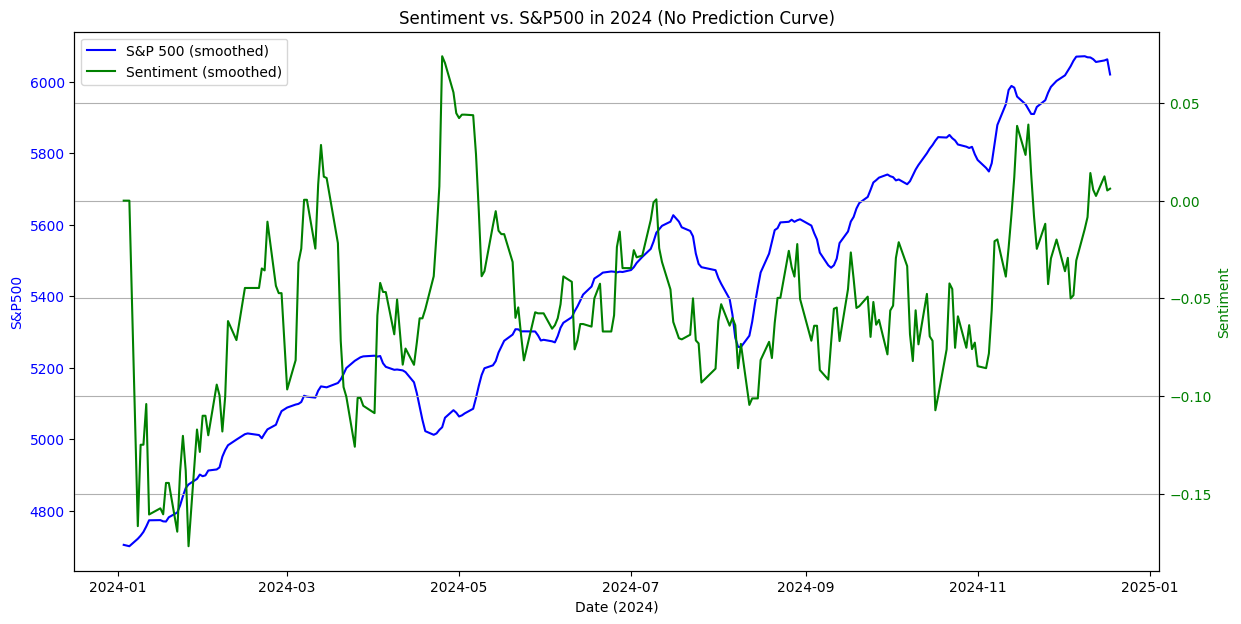

In [89]:
# ============ (七) 視覺化 (只顯示 2024 年範圍 + 不加預測) ============

def smooth_curve(y, window=5):
    return pd.Series(y).rolling(window=window, min_periods=1).mean().values

# 篩選 2024 年
df_plot = df_merged.copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot = df_plot[df_plot['date'].dt.year == 2024].copy()
df_plot.set_index('date', inplace=True)

# 重新計算 sentiment = (mean_article + mean_content)/2 用於繪圖
df_plot['actual_sentiment'] = (df_plot['mean_article'] + df_plot['mean_content']) / 2

# 平滑處理
df_plot['sp_smooth'] = smooth_curve(df_plot['sp_close'], window=5)
df_plot['sent_smooth'] = smooth_curve(df_plot['actual_sentiment'], window=10)

fig, ax1 = plt.subplots(figsize=(14,7))

# 繪製 S&P500
ax1.plot(df_plot.index, df_plot['sp_smooth'], color='blue', label='S&P 500 (smoothed)')
ax1.set_xlabel('Date (2024)')
ax1.set_ylabel('S&P500', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 繪製 sentiment
ax2 = ax1.twinx()
ax2.plot(df_plot.index, df_plot['sent_smooth'], color='green', label='Sentiment (smoothed)')
ax2.set_ylabel('Sentiment', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 合併圖例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("Sentiment vs. S&P500 in 2024 (No Prediction Curve)")
plt.grid(True)
plt.show()


In [ ]:
# ============ (八) 輸出合併後資料 ============

df_merged.to_csv("merged_data.csv", index=False)
print("merged_data.csv 已輸出.")
